In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()
plt.rcParams.update({'figure.facecolor':'white'})

from IPython.display import display

# prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_squared_error as MSE

## Import train and test data

In [31]:
# import train data and format timestamp column
df = pd.read_csv('../data/cleaned_sensors_dwd_train.csv', index_col=0)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [32]:
# import test data and format timestamp column
df_test = pd.read_csv('../data/cleaned_sensors_dwd_test.csv', index_col=0)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

## Choose location to be predcited

In [33]:
# looking for most complete location
df.groupby(['location_id'], dropna=False).PM2p5.count().sort_values()

location_id
79      6849
94      6952
27      9377
44     11246
121    11289
       ...  
12     17272
97     17295
99     17310
33     17325
98     17335
Name: PM2p5, Length: 66, dtype: int64

In [34]:
# choose the following location:
location = 37
print(f'location {location} has', round(df.query(f'location_id=={location}').PM2p5.count() / df.query(f'location_id=={location}').shape[0] * 100,1), '% of possible data')
display(df.query(f'location_id=={location}').describe().T)
display(df.query(f'location_id=={location}').loc[824567:824568,['location_id', 'city', 'lat', 'lon']])

location 37 has 92.5 % of possible data


,count,mean,std,min,25%,50%,75%,max
location_id,17544.0,37.000000,0.000000e+00,37.000000,37.000000,37.000000,37.000000,37.000000
lat,17544.0,50.108000,1.421126e-14,50.108000,50.108000,50.108000,50.108000,50.108000
lon,17544.0,8.640000,0.000000e+00,8.640000,8.640000,8.640000,8.640000,8.640000
PM10,16223.0,0.745049,1.629512e+00,0.000000,0.236364,0.378571,0.673058,32.247600
PM10_std,16207.0,0.825671,1.256057e+00,0.000000,0.203784,0.468624,1.020169,57.547966
PM2p5,16223.0,0.425799,7.559857e-01,0.000000,0.197142,0.277917,0.419183,17.356800
PM2p5_std,16207.0,0.262346,4.922455e-01,0.000000,0.132964,0.211823,0.320640,37.398829
humidity_sensors,4870.0,71.094549,2.220646e+01,15.017391,53.527375,72.718182,92.554891,99.900000
humidity_std,15459.0,0.940286,2.405280e+00,0.000000,0.000000,0.000000,0.823102,25.351651
pressure_sensors,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,location_id,city,lat,lon


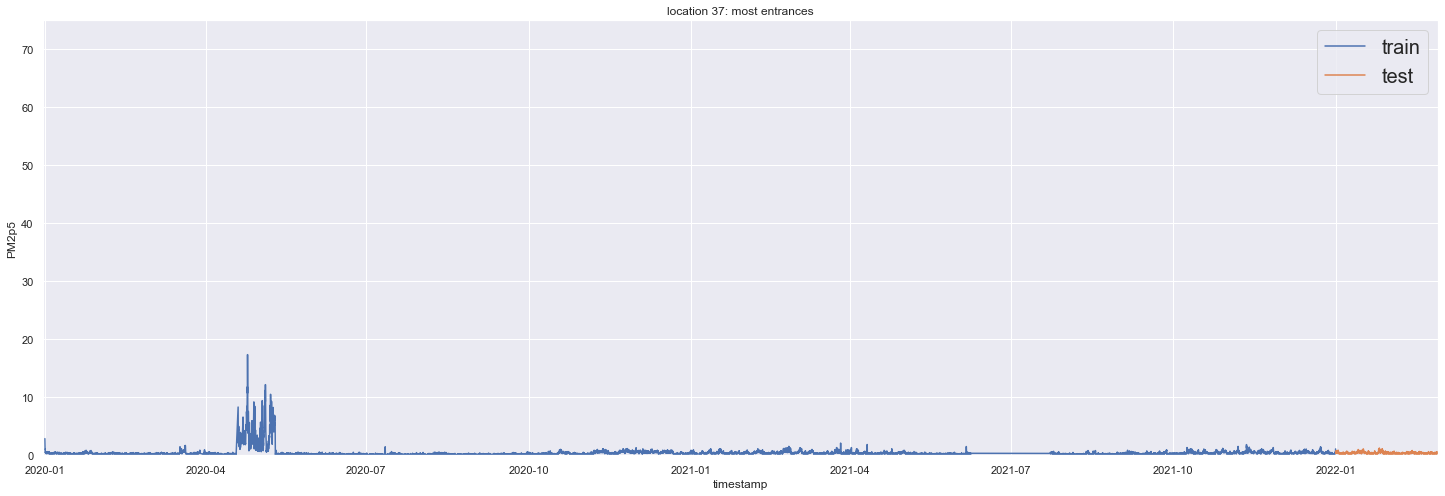

In [35]:
plt.figure(figsize=(25, 8))
plt.title(f'location {location}: most entrances')
sns.lineplot(data=df.query(f'location_id=={location}'), x='timestamp', y='PM2p5')
sns.lineplot(data=df_test.query(f'location_id=={location}'), x='timestamp', y='PM2p5')
plt.ylim(0,75)
plt.xlim(pd.to_datetime('2019-12-31'), pd.to_datetime('2022-02-28'))
plt.legend(['train', 'test'], fontsize=20)

## Prophet
### Train model
Trying model with (_reg) and without regressors.

In [41]:
# dictionary for comparison of results
models = {}
forecasts = {}


<AxesSubplot:xlabel='timestamp'>

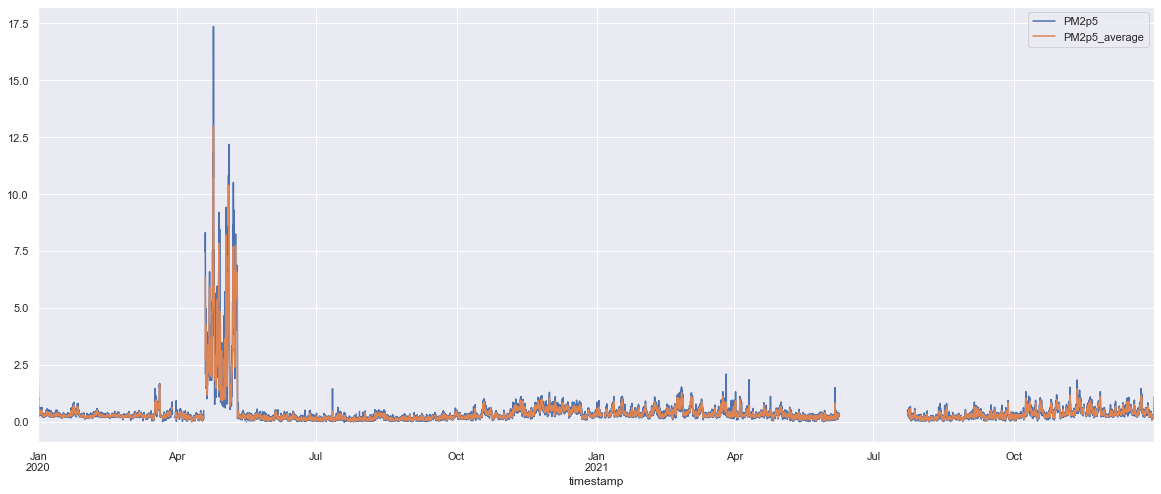

In [42]:
# calculate moving average of training data for cap and floor determination
df_average = df.query(f'location_id == {location}')[['timestamp','PM2p5']]
df_average['PM2p5_average'] = (df_average.PM2p5.shift(2) + df_average.PM2p5.shift(1) + df_average.PM2p5 + df_average.PM2p5.shift(-1) + df_average.PM2p5.shift(-2)) / 5

df_average.plot(x='timestamp', figsize=(20,8))
#plt.ylim(0,(df_average.PM2p5_average.max())


> Average calculation has flattened the curve, but Silvester peak remains. For this we'll take quantile(0.99) as PM2p5 cap.
> For PM2p5 floor we'll take the minimum of the moving average

In [43]:
# reduce data to one location
df_prophet = df.query(f'location_id == {location}')[['timestamp','PM2p5']]
df_prophet_reg = df.query(f'location_id == {location}')[['timestamp','PM2p5', 'humidity_dwd', 'temperature_dwd', 'pressure_dwd', 'wind_speed', 'precip', 'wind_direction']] 

# rename columns to expected format for prophet
df_prophet.rename(columns={'timestamp': 'ds', 'PM2p5': 'y'}, inplace=True)
df_prophet_reg.rename(columns={'timestamp': 'ds', 'PM2p5': 'y', 'humidity_dwd': 'humi', 'temperature_dwd': 'temp', 'pressure_dwd': 'press', 'wind_speed': 'windsp', 'precip': 'precip', 'wind_direction': 'wind_direction'}, inplace=True)

# prophet can not handle nans in dataframe
df_prophet.dropna(inplace=True)
df_prophet_reg.dropna(inplace=True)

# add cap column for to set growth = logistic
cap = df_average.PM2p5_average.quantile(0.99)
floor = df_average.PM2p5_average.min()
df_prophet['cap'] = cap 
df_prophet_reg['cap'] =  cap 
df_prophet['floor'] = floor 
df_prophet_reg['floor'] = floor


In [44]:
display(df_prophet)
display(df_prophet_reg)


,ds,y,cap,floor
298248,2020-01-01 00:00:00,2.870000,4.470393,0.008334
298249,2020-01-01 01:00:00,1.887917,4.470393,0.008334
298250,2020-01-01 02:00:00,1.021250,4.470393,0.008334
298251,2020-01-01 03:00:00,0.960000,4.470393,0.008334
298252,2020-01-01 04:00:00,1.033043,4.470393,0.008334
...,...,...,...,...
315787,2021-12-31 19:00:00,0.546250,4.470393,0.008334
315788,2021-12-31 20:00:00,0.596800,4.470393,0.008334
315789,2021-12-31 21:00:00,0.308750,4.470393,0.008334
315790,2021-12-31 22:00:00,0.396000,4.470393,0.008334


,ds,y,humi,temp,press,windsp,precip,wind_direction,cap,floor
298248,2020-01-01 00:00:00,2.870000,90.0,0.0,1023.1,2.7,0.0,40.0,4.470393,0.008334
298249,2020-01-01 01:00:00,1.887917,90.0,0.1,1022.9,2.8,0.0,20.0,4.470393,0.008334
298250,2020-01-01 02:00:00,1.021250,92.0,-1.1,1022.8,2.2,0.0,70.0,4.470393,0.008334
298251,2020-01-01 03:00:00,0.960000,93.0,-0.4,1022.3,1.6,0.0,80.0,4.470393,0.008334
298252,2020-01-01 04:00:00,1.033043,90.0,0.2,1022.1,2.0,0.0,50.0,4.470393,0.008334
...,...,...,...,...,...,...,...,...,...,...
315787,2021-12-31 19:00:00,0.546250,83.0,10.6,1011.2,2.6,0.0,180.0,4.470393,0.008334
315788,2021-12-31 20:00:00,0.596800,83.0,10.9,1011.9,3.5,0.0,200.0,4.470393,0.008334
315789,2021-12-31 21:00:00,0.308750,82.0,11.2,1012.2,3.3,0.0,200.0,4.470393,0.008334
315790,2021-12-31 22:00:00,0.396000,83.0,11.6,1012.3,3.0,0.0,210.0,4.470393,0.008334


In [45]:
# init Prophet model and fit it to train data
# without regressors

seasonality_mode='additive'
yearly_seasonality=True
weekly_seasonality=True
daily_seasonality=True
growth='logistic'
n_changepoints=20


model = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality, daily_seasonality=daily_seasonality,
        growth=growth,n_changepoints=n_changepoints)
model.fit(df_prophet);

# with regressors
model_reg = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality,
                     daily_seasonality=daily_seasonality, growth=growth,n_changepoints=n_changepoints)
model_reg.add_regressor('temp', standardize=True, prior_scale=0.25)
model_reg.add_regressor('humi', standardize=True, prior_scale=0.30)
model_reg.add_regressor('press', standardize=True, prior_scale=0.09)
model_reg.add_regressor('windsp', standardize=True, prior_scale=0.26)
model_reg.add_regressor('wind_direction', standardize=True, prior_scale=0.09)
model_reg.fit(df_prophet_reg)


  0%|          | 0/4 [3:42:21<?, ?it/s]


Initial log joint probability = -87.5768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       45226.5    0.00672257       511.835      0.5084           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       45243.6     0.0151097        854.14           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       45258.1      0.014453       586.527      0.2337           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345         45262    4.6757e-05        111.23   2.055e-07       0.001      442  LS failed, Hessian reset 
     380       45262.7   4.17253e-05       90.4056   2.694e-07       0.001      528  LS failed, Hessian reset 
     399       45263.9    0.00149731       151.917           1           1      550   
    Iter      log pro

Initial log joint probability = -87.0067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       44493.6     0.0172805        5154.5           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       44514.3   0.000424467       264.324       0.647       0.647      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         44532   2.05288e-05       111.054           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       44550.1    0.00139536       374.335           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       44556.7   0.000812886       222.832           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [46]:
# save model
without_reg = '9'
with_reg = '10'
models[without_reg] = model
models[with_reg] = model_reg

### Predict

In [47]:
def create_regressor_column(ds, train_col, test_col, location_id):
    """Get a regressor of train or test data for corresponding timestamp

    Args:
        ds (datetime): timestamp
        train_col (string): column name of regressor in train data
        test_col (string): column name of regressor in test data

    Returns:
        float: regressor value for given timestamp
    """
    
    if ds in df_prophet_reg['ds'].values:
        return df_prophet_reg[df_prophet_reg['ds'] == ds][train_col].values[0]
    elif ds in df_test['timestamp'].values:
        return df_test[(df_test['timestamp'] == ds) & (df_test['location_id'] == location_id)][test_col].values[0]
    else:
        return np.nan
   

In [48]:
# without regressors: create dataframe for predictions of 10 days and predict 
future = model.make_future_dataframe(periods=240, freq='H')
future['cap'] = cap
future['floor'] = floor
forecast = model.predict(future)

# with regressors: create dataframe for predictions of 10 days 
future_reg = model.make_future_dataframe(periods=240, freq='H')
future_reg['temp'] = future_reg['ds'].apply(create_regressor_column, args=('temp', 'temperature_dwd', location))
future_reg['humi'] = future_reg['ds'].apply(create_regressor_column, args=('humi', 'humidity_dwd', location))
future_reg['press'] = future_reg['ds'].apply(create_regressor_column, args=('press', 'pressure_dwd', location))
future_reg['windsp'] = future_reg['ds'].apply(create_regressor_column, args=('windsp', 'wind_speed', location))
future_reg['wind_direction'] = future_reg['ds'].apply(create_regressor_column, args=('wind_direction', 'wind_direction', location))

# consider autocorrelation: shift PM values by 1 hour
#future_reg['y_1'] = future_reg['ds'].apply(create_regressor_column, args=('y', 'PM2p5', location)).shift(1)
#future_reg['y_1'][0] = 0
    # drop nans
future_reg.dropna(inplace=True)
    # predict
forecast_reg = model_reg.predict(future_reg)

In [49]:
# save forecast
forecasts[without_reg] = forecast
forecasts[with_reg] = forecast_reg
forecasts.keys

<function dict.keys>

(18992.0, 19003.0)

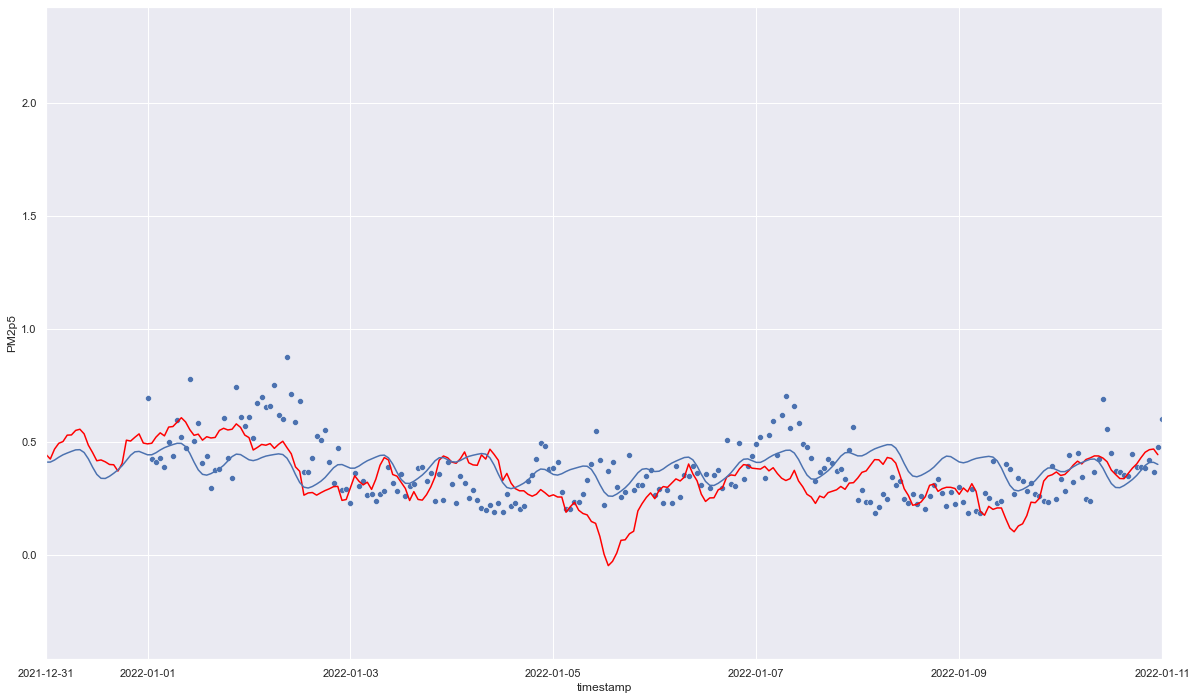

In [50]:
plt.figure(figsize=(20,12))
sns.scatterplot(df_test.query(f'location_id == {location}')['timestamp'], df_test.query(f'location_id == {location}')['PM2p5'])
#sns.lineplot(forecasts['1'].ds, forecasts['1'].yhat)
sns.lineplot(forecasts[with_reg].ds, forecasts[with_reg].yhat, color='red')
#sns.scatterplot(forecasts['2'].ds, forecasts['2'].yhat, collr='red)
sns.lineplot(forecasts[without_reg].ds, forecasts[without_reg].yhat)

plt.xlim(pd.to_datetime('2021-12-31'), pd.to_datetime('2022-01-11'))

### Show results

In [51]:
def plot_model_with_future(model, forecast, future, file, range_train):
    """plot the measured PM values together with forecast

    Args:
        model (_type_): _description_
        forecast (_type_): _description_
        future (_type_): _description_
        file (_type_): _description_
        range_train (_type_): _description_
    """
    fig = model.plot(forecast, ylabel='Value', figsize=(15, 8)) #xlabel='Date', 
    ax = fig.gca()
    sns.scatterplot(data=future, x='timestamp', y='PM2p5', ax=ax, color='green')
    #ax.set_title("Title", size=34)
    ax.set_xlabel("", size=34)
    ax.set_ylabel("PM 2.5 in µg/m³", size=34)
    ax.tick_params(axis="x", labelsize=24, rotation=90)
    ax.tick_params(axis="y", labelsize=24)
    
    ax.set_ylim(0, np.max(forecast.yhat) * 3) # set y-axis to 3 * max(yhat)
    ax.set_xlim(min(future.timestamp)- pd.Timedelta(days=range_train), min(future.timestamp) + pd.Timedelta(days=10)) # set x axis until test range and within range_train

    fig.savefig(file, bbox_inches='tight', facecolor="#EEEEEE")

    plt.show()

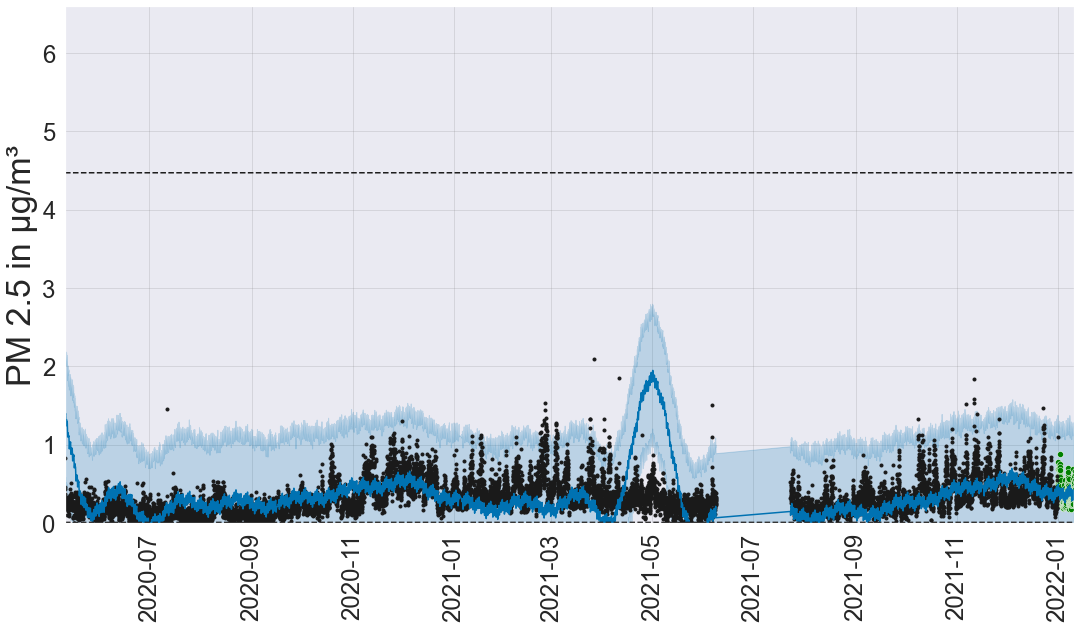

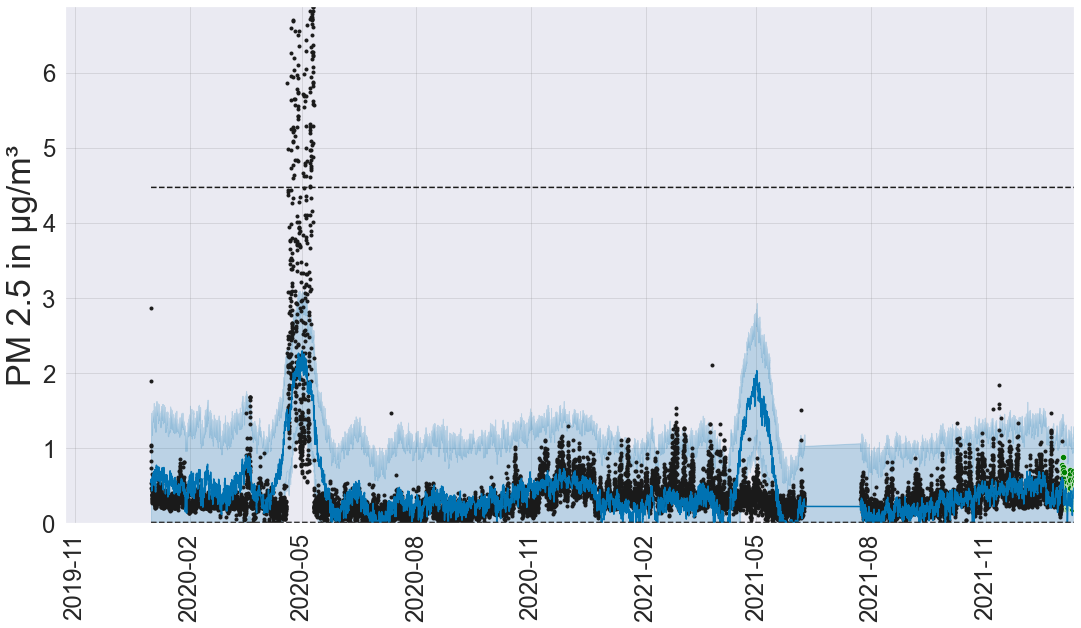

In [52]:
# plot
plot_model_with_future(model, forecast, df_test.query(f'location_id == {location}'), f'../images/prophet_location_id_{location}.png', 600)
plot_model_with_future(model_reg, forecast_reg, df_test.query(f'location_id == {location}'), f'../images/prophet_location_id_{location}.png', 800)


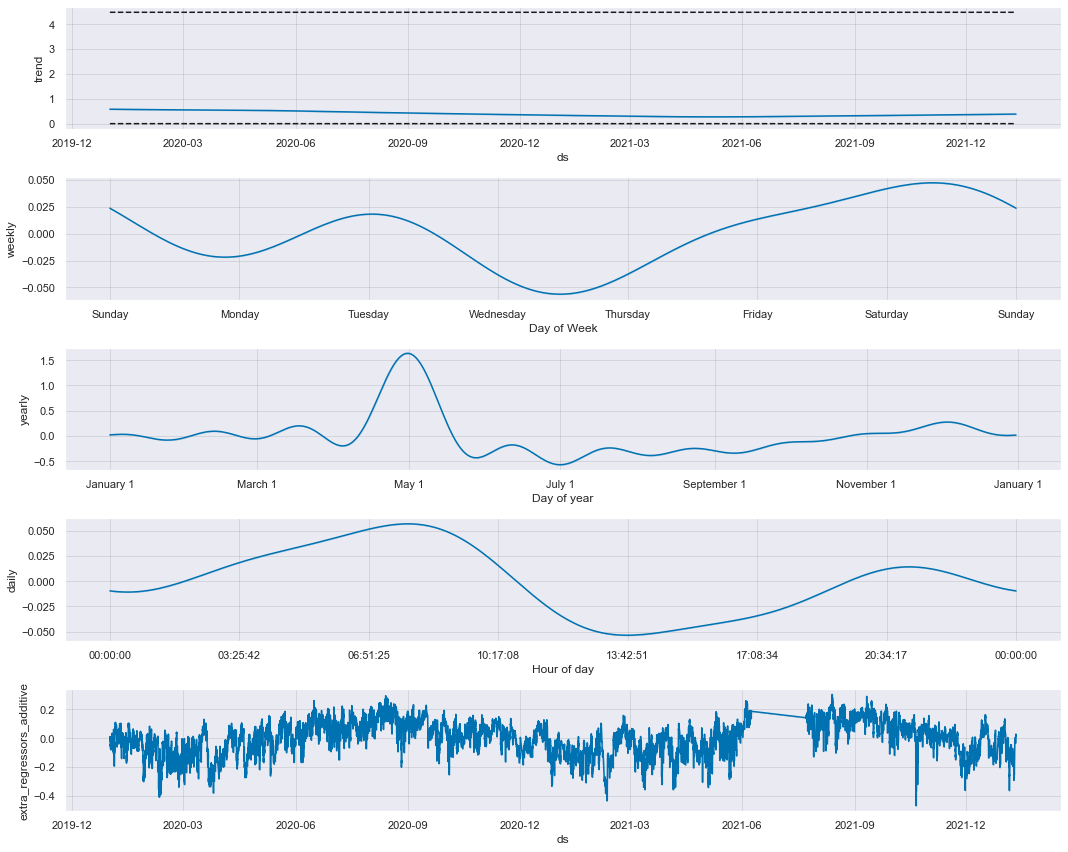

In [53]:
# plot components of models
fig = model_reg.plot_components(forecast_reg, figsize=(15, 12))
fig.savefig(f'../images/prophet_location_id_{location}_components.png', bbox_inches='tight', facecolor="#EEEEEE")

In [54]:
models.keys()

dict_keys(['9', '10'])

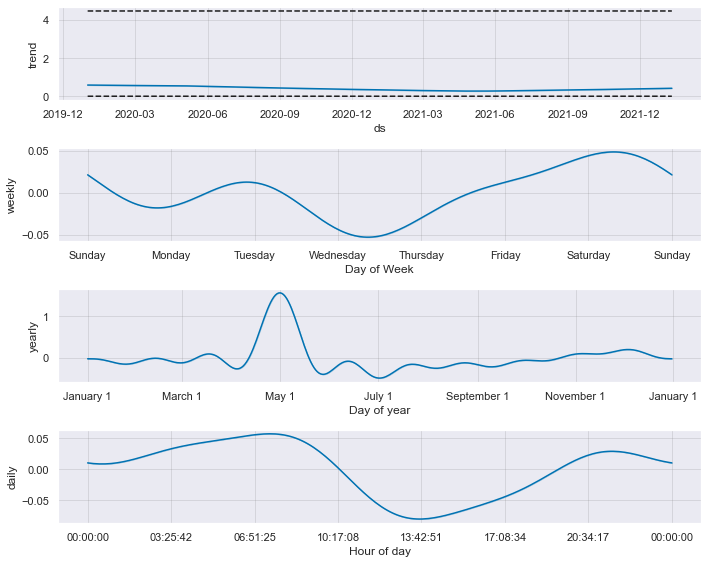

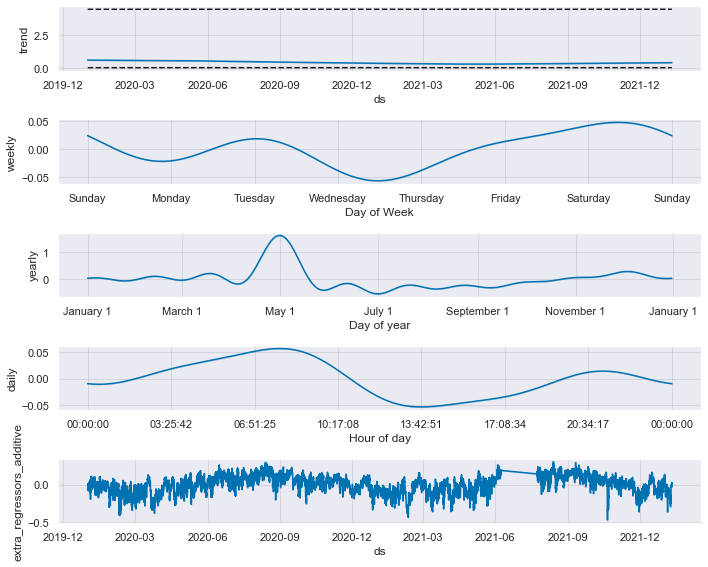

In [55]:
# plot components of models
#plt.figure(figsize=(20,15))
#plt.subplot(1,2,1)
fig = models[without_reg].plot_components(forecasts[without_reg], figsize=(10, 8))
#plt.subplot(1,2,2)
fig2 = models[with_reg].plot_components(forecasts[with_reg], figsize=(10, 8))

## Evaluate results
### Root Mean Squared Error (RMSE)

In [56]:
# limit columns of test data for calculating rmse
df_rmse_test = df_test.query(f"location_id == {location} and timestamp <= '{max(forecast.ds)}'")[['timestamp','PM2p5']]
df_rmse_test_reg = df_test.query(f"location_id == {location} and timestamp <= '{max(forecast_reg.ds)}'")[['timestamp','PM2p5']]
# use train data for calculating RMSE
df_rmse_train = df.query(f"location_id == {location} ")[['timestamp','PM2p5']]
df_rmse_train_reg = df.query(f"location_id == {location}")[['timestamp','PM2p5']]

# merge forecast to test data
df_rmse_test =     df_rmse_test.merge(forecast[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
df_rmse_test_reg = df_rmse_test_reg.merge(forecast_reg[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
df_rmse_train =      df_rmse_train.merge(forecast[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
df_rmse_train_reg =  df_rmse_train_reg.merge(forecast_reg[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)

# drop NaN
df_rmse_test.dropna(inplace=True)
df_rmse_test_reg.dropna(inplace=True)
df_rmse_train.dropna(inplace=True)
df_rmse_train_reg.dropna(inplace=True)

# calculate rmse for specific time span
rmse = MSE(df_rmse_test['PM2p5'], df_rmse_test['yhat'], squared=False)
rmse_reg = MSE(df_rmse_test_reg['PM2p5'], df_rmse_test_reg['yhat'], squared=False)
rmse_train = MSE(df_rmse_train['PM2p5'], df_rmse_train['yhat'], squared=False)
rmse_train_reg = MSE(df_rmse_train_reg['PM2p5'], df_rmse_train_reg['yhat'], squared=False)

# show result
print(f'RMSE test for location {location} = {round(rmse,2)} µg/m3')
print(f'RMSE train for location {location} = {round(rmse_train,2)} µg/m3')

print(f'RMSE test for location {location} with regressors = {round(rmse_reg,2)} µg/m3')
print(f'RMSE train for location {location} with regressors = {round(rmse_train_reg,2)} µg/m3')


RMSE test for location 37 = 0.14 µg/m3
RMSE train for location 37 = 0.64 µg/m3
RMSE test for location 37 with regressors = 0.15 µg/m3
RMSE train for location 37 with regressors = 0.64 µg/m3


### Cross validation

In [57]:
df_cv = cross_validation(model_reg, 
                         horizon="10 days",
                         period="116.25 days", # every quarter of a year
                         initial="365 days", # a year
                         parallel=None
                        )

INFO:prophet:Making 4 forecasts with cutoffs between 2021-01-07 05:00:00 and 2021-12-21 23:00:00
  0%|          | 0/4 [00:00<?, ?it/s]

Initial log joint probability = -37.5463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23455.4   0.000833842        290.89      0.7665      0.7665      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         23467     0.0472104        1075.7           1           1      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23470.9    0.00141702        326.41      0.9883      0.9883      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23474.7   8.40547e-05       339.819      0.4026      0.4026      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       23475.3   4.72972e-09       1189.51   2.988e-08           1      495   
Optimization terminated normally: 
  Convergence detected: absol

 25%|██▌       | 1/4 [00:05<00:15,  5.19s/it]

Initial log joint probability = -40.2278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30403.7    0.00383365       1364.96           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30501.2    0.00505225        865.95           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30505.3   0.000254261       237.904           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30517.9    0.00439144       841.346           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       30527.2    0.00104634       327.798           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

 50%|█████     | 2/4 [00:18<00:19,  9.90s/it]

Initial log joint probability = -41.7916
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       35257.6    0.00316785       1399.27           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       35320.5    0.00661897       1022.05           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       35328.1   0.000507384       155.724           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       35330.8    0.00182109       332.061           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       35344.7    0.00785338       430.644           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

 75%|███████▌  | 3/4 [00:40<00:15, 15.31s/it]

Initial log joint probability = -62.9999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       43772.2    0.00281917       2091.88           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       43786.8   0.000721647        402.95           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       43811.8    0.00650423       1777.71           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       43823.5   0.000108293       652.673      0.1486           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       43831.6     0.0129808       786.951           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

100%|██████████| 4/4 [00:54<00:00, 13.57s/it]


In [58]:
#df_p = performance_metrics(df_cv, rolling_window=1)
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-07 06:00:00,0.291721,-0.630502,1.154782,0.522609,2021-01-07 05:00:00
1,2021-01-07 07:00:00,0.283579,-0.581599,1.118525,0.581304,2021-01-07 05:00:00
2,2021-01-07 08:00:00,0.280420,-0.637945,1.216440,0.500476,2021-01-07 05:00:00
3,2021-01-07 09:00:00,0.266090,-0.643525,1.155316,0.421304,2021-01-07 05:00:00
4,2021-01-07 10:00:00,0.240662,-0.661231,1.130052,0.792727,2021-01-07 05:00:00
...,...,...,...,...,...,...
936,2021-12-31 19:00:00,0.489977,-0.334185,1.367165,0.546250,2021-12-21 23:00:00
937,2021-12-31 20:00:00,0.488580,-0.376764,1.328502,0.596800,2021-12-21 23:00:00
938,2021-12-31 21:00:00,0.506647,-0.333385,1.362281,0.308750,2021-12-21 23:00:00
939,2021-12-31 22:00:00,0.523310,-0.347458,1.300515,0.396000,2021-12-21 23:00:00


In [59]:
df_pm = performance_metrics(df_cv, rolling_window=0)
df_pm

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 01:00:00,0.858917,0.926778,0.601320,2.413357,0.789838,1.154611,0.75
1,0 days 02:00:00,0.828498,0.910219,0.638762,2.081760,0.831623,1.246499,0.75
2,0 days 03:00:00,0.915366,0.956747,0.649438,3.622200,0.766208,1.219790,0.75
3,0 days 04:00:00,0.779028,0.882625,0.557193,1.933044,0.672825,1.049647,0.75
4,0 days 05:00:00,0.880451,0.938324,0.671155,2.303776,0.716882,1.140057,0.75
...,...,...,...,...,...,...,...,...
235,9 days 20:00:00,0.321963,0.567418,0.482365,1.065896,1.197464,1.095752,0.75
236,9 days 21:00:00,0.284158,0.533065,0.462373,0.990088,1.112008,1.056671,1.00
237,9 days 22:00:00,0.472189,0.687160,0.597686,1.547254,1.298645,1.257476,0.75
238,9 days 23:00:00,0.402878,0.634727,0.514990,1.898051,1.210548,1.217718,0.75


<AxesSubplot:xlabel='horizon'>

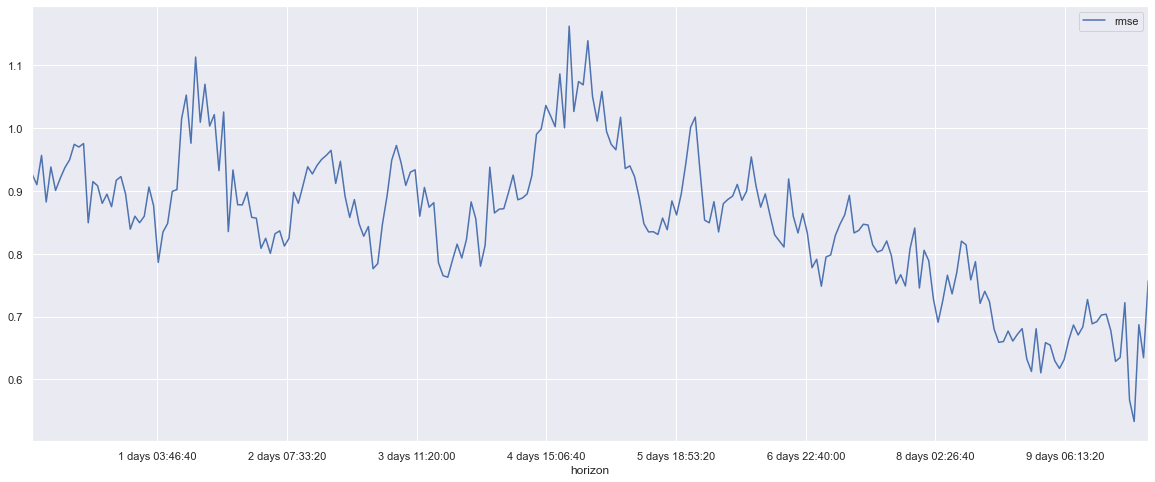

In [60]:
df_pm.plot(x='horizon', y='rmse', figsize=(20,8))
#plt.xticks(range=(1,10,1))
#plt.xticks(np.arange(df_pm['horizon'].min(), df_pm['horizon'].max(), 1));